In [77]:
import numpy as np
import pandas as pd
from IPython.core.debugger import set_trace
from tqdm import tqdm_notebook
%matplotlib inline

# DB 만들기

In [92]:
pd.read_excel('quantking.xlsx', sheet_name='x').to_excel('quantking_x.xlsx', sheet_name='data')

In [93]:
fin = pd.read_excel('quantking_db.xlsx', sheet_name='fin', index_col=[0], header=[0,1])
mc = pd.read_excel('quantking_db.xlsx', sheet_name='mc', index_col=[0], header=[0])
info = pd.read_excel('quantking_db.xlsx', sheet_name='info', index_col=[0])

In [94]:
fin = fin.stack()
mc = mc.T

In [105]:
fin.to_pickle('fin.pkl')
mc.to_pickle('mc.pkl')
info.to_pickle('info.pkl')

In [76]:
fin.to_excel('fin.xlsx', sheet_name='fin')
mc.to_excel('mc.xlsx', sheet_name='mc')

In [4]:
fin = pd.read_pickle('fin.pkl')
mc = pd.read_pickle('mc.pkl')
info = pd.read_pickle('info.pkl')

# 전략 만들기

In [78]:
def get_fisyear(date):
    if type(date)==str:
        date = pd.Timestamp(date)
    
    if date.month >= 6:
        return date.year - 1
    
    else:
        return date.year - 2
    
    
def 매출상위(date, fin=None, mc=None, n=10):
    fisyear = get_fisyear(date)
    position = fin['매출액'].xs(fisyear, level=1).nlargest(n)
    position[:] = 1/len(position)
    return position


def 매출상위다시(date, fin=None, mc=None, n=10):
    fisyear = get_fisyear(date)
    univ = mc.columns[mc.loc[date]>0]
    position = fin['매출액'].xs(fisyear, level=1).loc[univ].nlargest(n)
    position[:] = 1/len(position)
    return position

def BM(date, fin=None, mc=None, n=200):
    position = mc.loc[date].nlargest(n)
    position /= position.sum()
    return position

In [79]:
매출상위('2019-03-31', fin=fin, mc=mc)

A005930    0.1
A005380    0.1
A034730    0.1
A066570    0.1
A005490    0.1
A015760    0.1
A000270    0.1
A000880    0.1
A096770    0.1
A012330    0.1
Name: 매출액, dtype: float64

# 백테스터

In [81]:
def evaluate(nav, pos, date_prev, date, mc):
    nav_prev = nav[date_prev]
    pos_prev = pos[date_prev]
    assets_prev = pos_prev.index
    pos_update = mc.loc[date, assets_prev] / mc.loc[date_prev, assets_prev] * pos_prev
    return nav_prev * pos_update.sum()

In [82]:
dates = mc.index[8:]
pos = {}
nav = {}
pos_bm = {}
nav_bm = {}
n = 10

for i,date in enumerate(dates):
    pos[date] = 매출상위(date, fin=fin, mc=mc, n=n)
    pos_bm[date] = BM(date, fin=fin, mc=mc)
    
    if i==0:
        nav[date] = 1
        nav_bm[date] = 1
    
    else:
        date_prev = dates[i-1]
        nav[date] = evaluate(nav, pos, date_prev, date, mc)
        nav_bm[date] = evaluate(nav_bm, pos_bm, date_prev, date, mc)

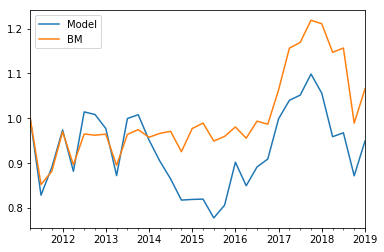

In [83]:
pd.DataFrame({'Model':nav, 'BM':nav_bm}).plot()

# 더 좋은 백테스터

In [95]:
class Backtest:
    def __init__(self, model=None, bm=None, fin=None, mc=None, info=None, n=10):
        self.model = model
        self.bm = bm
        self.fin = fin
        self.mc = mc
        self.info = info
        self.n = n

    def run(self): 
        dates = self.mc.index[8:]
        pos = {}
        nav = {}
        pos_bm = {}
        nav_bm = {}

        for i,date in enumerate(tqdm_notebook(dates)):
            pos[date] = self.model(date, fin=self.fin, mc=self.mc, n=self.n)
            pos_bm[date] = self.bm(date, fin=self.fin, mc=self.mc)

            if i==0:
                nav[date] = 1
                nav_bm[date] = 1

            else:
                date_prev = dates[i-1]
                nav[date] = self.evaluate(nav, pos, date_prev, date)
                nav_bm[date] = self.evaluate(nav_bm, pos_bm, date_prev, date)

        self.nav = nav
        self.pos = pos
        self.nav_bm = nav_bm
        self.pos_bm = pos_bm


    def evaluate(self, nav, pos, date_prev, date):
        nav_prev = nav[date_prev]
        pos_prev = pos[date_prev]
        assets_prev = pos_prev.index
        pos_update = self.mc.loc[date, assets_prev] / self.mc.loc[date_prev, assets_prev] * pos_prev
        return nav_prev * pos_update.sum()

    def navs(self):
        return pd.DataFrame({'Model':self.nav, 'BM':self.nav_bm})

    def plot_perf(self):
        self.navs().plot()

    def stats(self):
        _navs = self.navs()
        days_all = (_navs.index[-1]-_navs.index[0]).days
        ann_rtn = (_navs.iloc[-1]**(365/days_all))-1
        vol = _navs.pct_change().std() * 4**0.5
        return pd.DataFrame({'Annual return':ann_rtn, 'Volatility':vol, 'Sharpe':ann_rtn/vol})

    def position(self, date=None, what='model'):
        if what=='model':
            pos = self.pos
        elif what=='bm':
            pos = self.pos_bm

        if date is None:
            return pd.DataFrame(pos).T
        else:
            return pos[pd.Timestamp(date)]

In [96]:
def 시총상위PB저평가(date, fin=None, mc=None, n=10):
    fisyear = get_fisyear(date)
    marketcap = mc.loc[date].nlargest(100)
    univ = marketcap.index
    bv = fin['자본총계'].xs(fisyear, level=1).loc[univ]
    bp = bv / marketcap
    position = bp.nlargest(n)
    position[:] = 1/len(position)
    return position

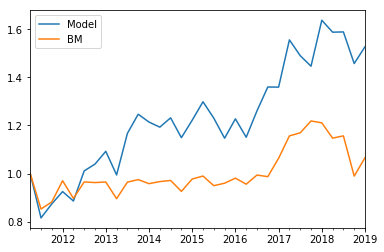

In [97]:
bt = Backtest(model=시총상위PB저평가, bm=BM, fin=fin, mc=mc, n=10)
bt.run()
bt.plot_perf()

In [98]:
bt.stats()

,Annual return,Volatility,Sharpe
Model,0.056093,0.162795,0.344563
BM,0.008227,0.121585,0.067661


In [99]:
bt.position(date='2019-03-31')

A015760    0.1
A001040    0.1
A088350    0.1
A005380    0.1
A004020    0.1
A023530    0.1
A034730    0.1
A024110    0.1
A086790    0.1
A034220    0.1
dtype: float64

In [100]:
def 슈퍼밸류(date, fin=None, mc=None, n=10):
    fisyear = get_fisyear(date)
    marketcap = mc.loc[date].nlargest(100)
    univ = marketcap.index
    _ni = fin['순익(단순)'].xs(fisyear, level=1)>0
    _bv = fin['자본총계'].xs(fisyear, level=1)>0
    _ocf = fin['영활현흐'].xs(fisyear, level=1)>0
    _ebitda = fin['EBITDA'].xs(fisyear, level=1)>0
    _dvd = fin['DPS'].xs(fisyear, level=1)>0
    screen = (_ni & _bv & _ocf & _ebitda & _dvd).loc[univ]
    univ = screen.index[screen]
    marketcap = marketcap.loc[univ]
    ni = fin['순익(단순)'].xs(fisyear, level=1).loc[univ]
    bv = fin['자본총계'].xs(fisyear, level=1).loc[univ]
    ocf = fin['영활현흐'].xs(fisyear, level=1).loc[univ]
    sales = fin['매출액'].xs(fisyear, level=1).loc[univ]
    ebitda = fin['EBITDA'].xs(fisyear, level=1).loc[univ]
    ev = fin['EV'].xs(fisyear, level=1).loc[univ]

    r_per = (ni/marketcap).rank()
    r_pbr = (bv/marketcap).rank()
    r_pcr = (ocf/marketcap).rank()
    r_psr = (sales/marketcap).rank()
    r_ee = (ebitda/ev).rank()

    r_total = r_per + r_pbr + r_pcr + r_psr + r_ee
    position = r_total.nlargest(n)
    position[:] = 1/len(position)
    
    return position

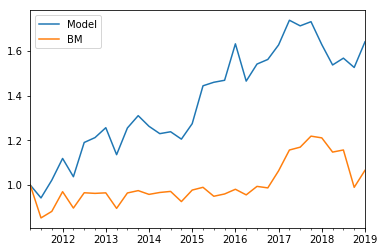

In [101]:
bt = Backtest(model=슈퍼밸류, bm=BM, fin=fin, mc=mc, n=10)
bt.run()
bt.plot_perf()